<a href="https://colab.research.google.com/github/AlEXSH3N/713-Music-Emotion-System/blob/data_cleaning/713_group_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
!pip install emoji
!pip install gensim
!pip install --user -U nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gensim
import warnings
import string
import emoji
import re
import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import Concatenate, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# from cuml.neighbors import KNeighborsClassifier
# from cuml.model_selection import train_test_split

## Data Loading

In [4]:
# /content/drive/Shareddrives/713 Group Project/Dataset/
goemo1 = pd.read_csv(r'/content/drive/Shareddrives/713 Group Project/Dataset/goemotions_1.csv')
goemo2 = pd.read_csv(r'/content/drive/Shareddrives/713 Group Project/Dataset/goemotions_2.csv')
goemo3 = pd.read_csv(r'/content/drive/Shareddrives/713 Group Project/Dataset/goemotions_3.csv')
goemo_all = pd.concat([goemo1, goemo2, goemo3], ignore_index=True)

print(len(goemo1), len(goemo2), len(goemo3), len(goemo_all))

70000 70000 71225 211225


In [5]:
goemo_all.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


## Data Exploration

In [8]:
emotion_initial_index = goemo_all.columns.tolist().index('admiration')
labels = goemo_all.columns.tolist()[emotion_initial_index:]
print(f"{labels} \n{len(labels)}")

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'] 
28


In [9]:
no_text_more_than_50 = 0
for text in goemo_all['text']:
    if len(text) > 50:
        no_text_more_than_50 += 1
print(f"Number of texts with more than 50 characters: {no_text_more_than_50}: {no_text_more_than_50/len(goemo_all)*100}%")

Number of texts with more than 50 characters: 136658: 64.69783406320275%


In [10]:
vec = CountVectorizer()
X = vec.fit_transform(goemo_all['text'])

words = vec.vocabulary_
sorted_words = sorted(words.items(), key=lambda x: x[1], reverse=True)
print(sorted_words)

[('ﾉωﾉ', 30698), ('카니발', 30697), ('병무청', 30696), ('개인면허', 30695), ('玛雅', 30694), ('查清', 30693), ('在中国你做什么', 30692), ('加油', 30691), ('中国人', 30690), ('ᴡᴀɪᴛ', 30689), ('ᴡᴀsᴛᴇ', 30688), ('ᴛʜɪs', 30687), ('ᴍɪɴᴜᴛᴇ', 30686), ('וליאן', 30685), ('ˈtechē', 30684), ('ˈsatʌɪə', 30683), ('ˈbɪɡət', 30682), ('ɹǝʍsuɐ', 30681), ('ɴᴏ', 30680), ('ɪs', 30679), ('ɢᴏᴏᴅ', 30678), ('òwó', 30677), ('ásáheill', 30676), ('zzzzzzz', 30675), ('zzzzzz', 30674), ('zumba', 30673), ('zullily', 30672), ('zugzwang', 30671), ('zucker', 30670), ('zucchini', 30669), ('zubac', 30668), ('zoos', 30667), ('zooming', 30666), ('zoomies', 30665), ('zoomed', 30664), ('zoom', 30663), ('zookeeper', 30662), ('zoo', 30661), ('zoning', 30660), ('zones', 30659), ('zone', 30658), ('zombies', 30657), ('zombie', 30656), ('zombey', 30655), ('zoey', 30654), ('zoetrope', 30653), ('zoe', 30652), ('zits', 30651), ('zippers', 30650), ('zipper', 30649), ('ziploc', 30648), ('zip', 30647), ('zionist', 30646), ('zionism', 30645), ('zion', 30644), ('

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65417 (\N{HALFWIDTH KATAKANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48337 (\N{HANGUL SYLLABLE BYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist

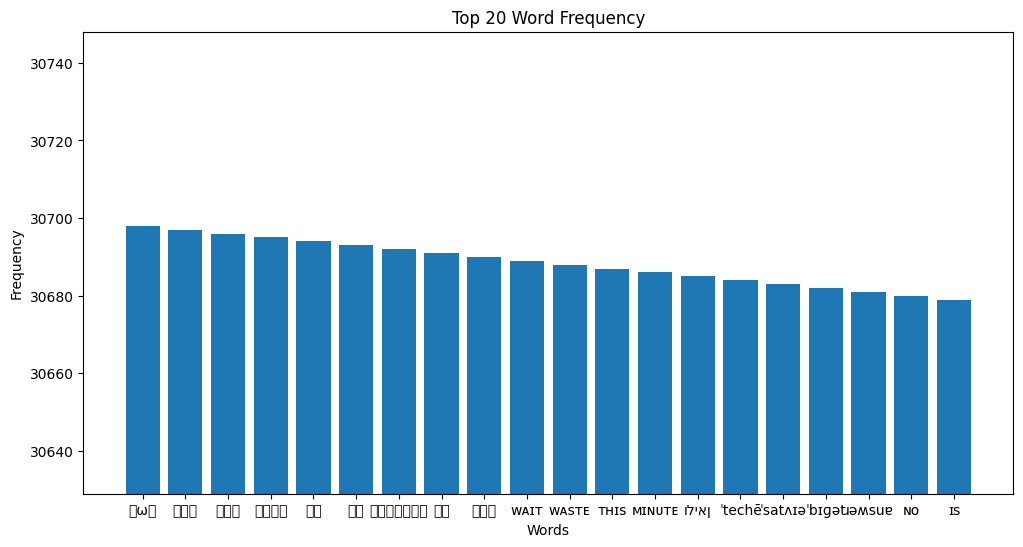

In [11]:
top_20_words = sorted_words[:20]
words, frequencies = zip(*top_20_words)

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequency')
plt.ylim(frequencies[-1] - 50, frequencies[0] + 50)
plt.show()

In [12]:
def count_punctuation(text):
    punctuations = string.punctuation
    concatenated = " ".join(text)
    punctuation_count = {}
    for char in concatenated:
        if char in punctuations:
            if char in punctuation_count:
                punctuation_count[char] += 1
            else:
                punctuation_count[char] = 1
    return punctuation_count

punctuation_count = count_punctuation(goemo_all["text"])
print(punctuation_count)


{'.': 229770, '>': 3348, '"': 12086, ',': 69932, "'": 73015, '!': 41885, '[': 37848, ']': 37831, '?': 25849, ';': 988, '/': 6151, '-': 9591, '<': 529, '$': 834, '(': 4325, ')': 5809, '#': 845, ':': 7648, '*': 9585, '_': 690, '|': 456, '%': 1022, '+': 593, '&': 403, '~': 1086, '^': 1646, '=': 461, '`': 25, '@': 138, '\\': 44, '{': 9, '}': 18}


In [13]:
num_names_list = [text.count('[NAME]') for text in goemo_all['text']]
num_names_list = list(filter(lambda x: x >= 5, num_names_list))
print(len(num_names_list))

77


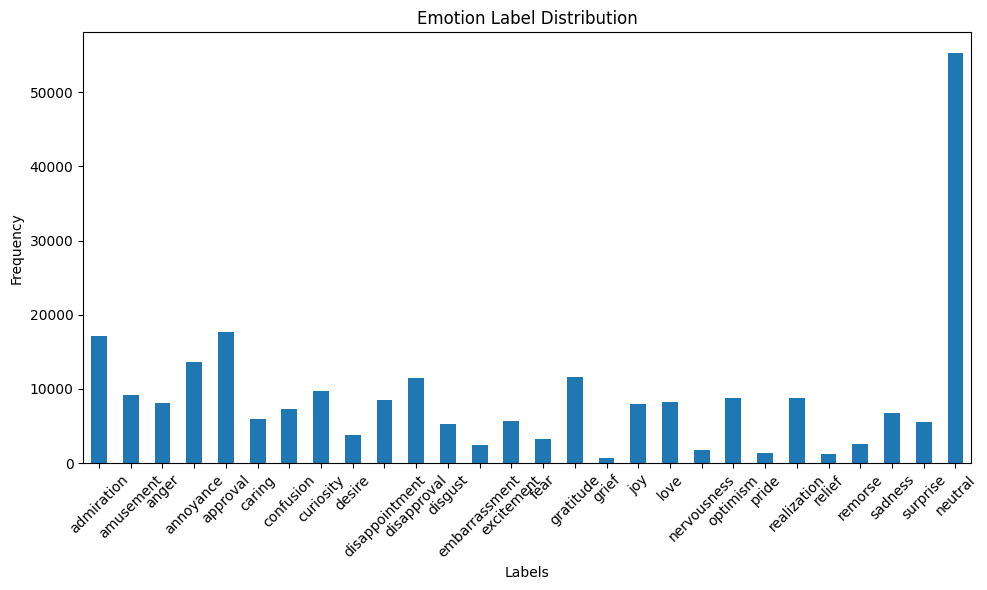

In [14]:
emotion_label_distribution = goemo_all[labels].sum()

plt.figure(figsize=(10, 6))
emotion_label_distribution.plot(kind='bar')
plt.title('Emotion Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
label_distribution_series = pd.Series(emotion_label_distribution, index=labels)
label_distribution_series_sorted = label_distribution_series.sort_values(ascending=False)

print("Label Distribution:")
print(label_distribution_series_sorted)

Label Distribution:
neutral           55298
approval          17620
admiration        17131
annoyance         13618
gratitude         11625
disapproval       11424
curiosity          9692
amusement          9245
realization        8785
optimism           8715
disappointment     8469
love               8191
anger              8084
joy                7983
confusion          7359
sadness            6758
caring             5999
excitement         5629
surprise           5514
disgust            5301
desire             3817
fear               3197
remorse            2525
embarrassment      2476
nervousness        1810
pride              1302
relief             1289
grief               673
dtype: int64


## Data Preprocessing

### Data Cleaning

In [16]:
necessary_features_to_keep = goemo_all.columns[:1].append(goemo_all.columns[emotion_initial_index:])
goemo_all_selected = goemo_all[necessary_features_to_keep]

In [17]:
label_columns = goemo_all_selected.columns[1:]
neutral_rows = goemo_all_selected[(goemo_all_selected['neutral'] == 1) & (goemo_all_selected[label_columns].sum(axis=1) > 1)]
count_neutral_more_than_1 = len(neutral_rows)

print("Number of rows where 'neutral' is 1 and total labels > 1:", count_neutral_more_than_1)

Number of rows where 'neutral' is 1 and total labels > 1: 0


In [18]:
neutral_indices = np.random.choice(goemo_all_selected[goemo_all_selected['neutral'] == 1].index, size=(label_distribution_series_sorted[0] - label_distribution_series_sorted[1]), replace=False)
geomo_all_neutral_undersampled = goemo_all_selected.drop(neutral_indices)

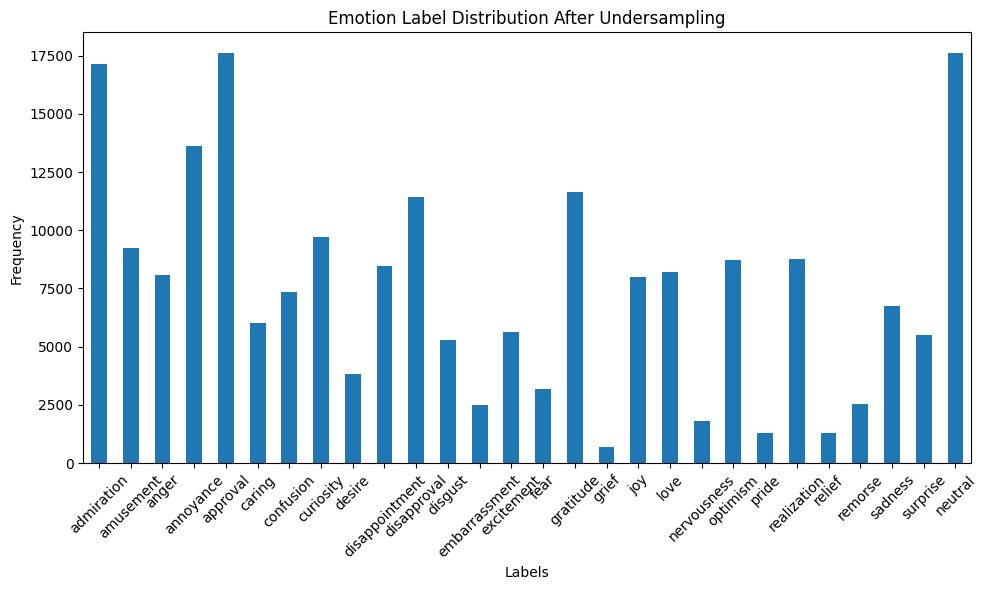

In [19]:
emotion_label_undersampled_distribution = geomo_all_neutral_undersampled[labels].sum()

plt.figure(figsize=(10, 6))
emotion_label_undersampled_distribution.plot(kind='bar')
plt.title('Emotion Label Distribution After Undersampling')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
emotion_label_distribution_undersampled = geomo_all_neutral_undersampled[labels].sum()
label_distribution_undersampled_series = pd.Series(emotion_label_distribution_undersampled, index=labels)
label_distribution_undersampled_series_sorted = label_distribution_undersampled_series.sort_values(ascending=False)

print("Label Distribution:")
print(label_distribution_undersampled_series_sorted)

Label Distribution:
neutral           17620
approval          17620
admiration        17131
annoyance         13618
gratitude         11625
disapproval       11424
curiosity          9692
amusement          9245
realization        8785
optimism           8715
disappointment     8469
love               8191
anger              8084
joy                7983
confusion          7359
sadness            6758
caring             5999
excitement         5629
surprise           5514
disgust            5301
desire             3817
fear               3197
remorse            2525
embarrassment      2476
nervousness        1810
pride              1302
relief             1289
grief               673
dtype: int64


In [21]:
print(len(geomo_all_neutral_undersampled))

173547


In [22]:
contraction_mapping = {'u.s':'america', 'e.g.':'for example', 'e.g': "for example"}
remove_words = ["they", "she", "need", "there", "this", "that", "those", "these", "should",
                "could", "ought", "would", "will", "have", "has", "had", "might", "may", "sha",
                "shall", "must", "are", "were", "was", "does", "did", "how", "who", "why",
                "what", "where", "when", "whose", "whom", "ain", "theyve", "Ive", "you",
                "theyre", "shes", "hes", "werent", "wasnt", "yall", "theirs", "yours", "his",
                "her", "hers", "him", "their", "them", "mine", "maam", "its"]
exception_two_words = ["yo", "ew", "ya", "um", "oh", "ok", "or", "eh", "aw", "hi", "ho", "ay", "ai",
                       "em", "if", "lo", "in", "op", "uh", "um", "ye"]
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization', "arent": "are not", "isnt": "is not", "aint": "not",  'coz': 'because', 'therefore': 'so', 'thus': 'so', 'hence': 'so'}
# t --> before cancel
# if t before is a can --> cannot
# remove single letter


In [23]:
def remove_name(text):
  return text.replace('[NAME]', '')

def replace_emoji_text(text):
  return emoji.demojize(text, delimiters=("", ""))

def contraction_mapping_fun(text):
  word_list = text.split(" ")
  length = len(word_list)

  for i in range(length - 1, -1, -1):
    word = word_list[i]
    if word == "":
      continue
    word = word.lower()
    if word == "t" and i > 0:
      if word_list[i-1] == "can":
        word_list[i-1] = "cannot"
      else:
        word_list[i] = "not"
        word_list[i-1] = ""
    elif len(word) <= 2 and word not in exception_two_words:
      word_list[i] = ""
    elif word in remove_words:
      word_list[i] = ""

  text = ' '.join(map(str, word_list))
  return text

def mispelled_word(text):
  word_list = text.split(" ")
  length = len(word_list)
  for i in range(length - 1, -1, -1):
    word = word_list[i].lower()
    if word in mispell_dict:
      word_list[i] = mispell_dict[word]

  text = ' '.join(map(str, word_list))
  return text

def retain_english_text(text):
  word_list = text.split(" ")
  for i in range(len(word_list)):
    ele = word_list[i].lower()
    if ele in contraction_mapping:
      word_list[i] = contraction_mapping[ele]

  text = ' '.join(map(str, word_list))
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = mispelled_word(text)
  text = contraction_mapping_fun(text)
  return text

def data_cleaning_pipeline(text):
  text = remove_name(text)
  text = replace_emoji_text(text)
  text = retain_english_text(text)
  text = " ".join(text.split())
  return text

In [24]:
geomo_all_neutral_undersampled['text'] = geomo_all_neutral_undersampled['text'].apply(data_cleaning_pipeline)

In [25]:
geomo_all_neutral_undersampled.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,game hurt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,sexuality shouldnt grouping category makes dif...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Man love reddit,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,nowhere near the Falcon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,Right Considering such important document know...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
def count_short_strings(df):
    return ((df['text'].str.len() == 0) | (df['text'].str.len() == 1)).sum()

# Example usage
short_string_count = count_short_strings(geomo_all_neutral_undersampled)
print("Number of rows with text of length 0 or 1:", short_string_count)

Number of rows with text of length 0 or 1: 318


In [27]:
geomo_all_neutral_undersampled = geomo_all_neutral_undersampled[(geomo_all_neutral_undersampled['text'].str.len() > 1)]
geomo_all_neutral_undersampled.reset_index(drop=True, inplace=True)
print(f'Number of rows: {len(geomo_all_neutral_undersampled)}')

Number of rows: 173229


In [28]:
vec_cleaned = CountVectorizer()
X_cleaned = vec_cleaned.fit_transform(geomo_all_neutral_undersampled['text'])

words_cleaned = vec_cleaned.vocabulary_
sorted_words_cleaned = sorted(words_cleaned.items(), key=lambda x: x[1], reverse=True)
print(sorted_words_cleaned)

[('zzzzzzz', 31580), ('zzzzzz', 31579), ('zumba', 31578), ('zullily', 31577), ('zugzwang', 31576), ('zucker', 31575), ('zucchini', 31574), ('zubac', 31573), ('ztargeting', 31572), ('zoos', 31571), ('zooming', 31570), ('zoomies', 31569), ('zoomed', 31568), ('zoom', 31567), ('zookeeper', 31566), ('zoo', 31565), ('zoning', 31564), ('zones', 31563), ('zone', 31562), ('zombies', 31561), ('zombielike', 31560), ('zombie', 31559), ('zombey', 31558), ('zoey', 31557), ('zoetrope', 31556), ('zoe', 31555), ('zits', 31554), ('zippers', 31553), ('zipper', 31552), ('ziploc', 31551), ('zip', 31550), ('zionist', 31549), ('zionism', 31548), ('ziondraft', 31547), ('zion', 31546), ('zinger', 31545), ('zinfandel', 31544), ('zimm', 31543), ('zim', 31542), ('zilliqa', 31541), ('ziip', 31540), ('zigzagzigaltype', 31539), ('ziggy', 31538), ('zeros', 31537), ('zeroh', 31536), ('zerocarbers', 31535), ('zerocalorie', 31534), ('zero', 31533), ('zer', 31532), ('zeppelin', 31531), ('zepellin', 31530), ('zen', 31529)

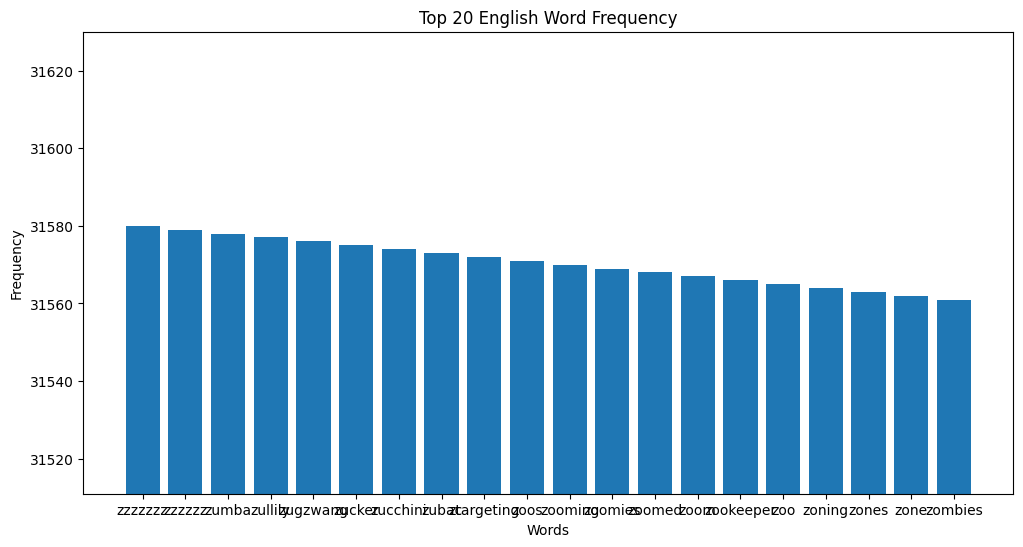

In [29]:
top_20_words_cleaned = sorted_words_cleaned[:20]
words_cleaned, frequencies_cleaned = zip(*top_20_words_cleaned)

plt.figure(figsize=(12, 6))
plt.bar(words_cleaned, frequencies_cleaned)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 English Word Frequency')
plt.ylim(frequencies_cleaned[-1] - 50, frequencies_cleaned[0] + 50)
plt.show()

In [30]:
full_train_data, test_data = train_test_split(geomo_all_neutral_undersampled, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(full_train_data, test_size=0.25, random_state=42)

In [31]:
y_train = train_data[labels].values
y_val = val_data[labels].values
y_test = test_data[labels].values
y_full_train = full_train_data[labels].values

In [59]:
X_full_train = full_train_data.iloc[:, 0].values
X_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 0].values
X_val = val_data.iloc[:, 0].values

### Word Tokenizer

In [60]:
tokenizer = nltk.word_tokenize

tokenized_texts_full_train = [tokenizer(text) for text in X_full_train]
tokenized_texts_train = [tokenizer(text) for text in X_train]
tokenized_texts_test = [tokenizer(text) for text in X_test]
tokenized_texts_val = [tokenizer(text) for text in X_val]

model = gensim.models.Word2Vec(tokenized_texts_train, vector_size=100, window=5, min_count=1, workers=4)


In [61]:
full_train_word_vectors = [np.mean([model.wv[w] for w in tokens if w in model.wv] or [np.zeros(model.vector_size)], axis=0) for tokens in tokenized_texts_full_train]
train_word_vectors = [np.mean([model.wv[w] for w in tokens if w in model.wv] or [np.zeros(model.vector_size)], axis=0) for tokens in tokenized_texts_train]
test_word_vectors = [np.mean([model.wv[w] for w in tokens if w in model.wv] or [np.zeros(model.vector_size)], axis=0) for tokens in tokenized_texts_test]
val_word_vectors = [np.mean([model.wv[w] for w in tokens if w in model.wv] or [np.zeros(model.vector_size)], axis=0) for tokens in tokenized_texts_val]

In [66]:
print(len(X_train), len(train_word_vectors))

103937 103937


In [1]:
tfidf = TfidfVectorizer(tokenizer=tokenizer)
tfidf_matrix_train = tfidf.fit_transform(X_train)
tfidf_array_train = tfidf_matrix_train.toarray()

NameError: name 'TfidfVectorizer' is not defined

In [ ]:
weighted_train_vectors = []
print(len(train_word_vectors[i]))

In [ ]:
# for i in range(len(X_train)):
#     tfidf_weights = tfidf_array_train[i]
#     weighted_vector = np.dot(tfidf_weights, train_word_vectors[i])
#     weighted_train_vectors.append(weighted_vector)

In [ ]:
# logistic_classifier = LogisticRegression(multi_class='ovr')
# logistic_classifier.fit(weighted_train_vectors, y_train)

In [72]:
# ovr_prediction = logistic_classifier.predict(X_val)
# ovr_accuracy = round(accuracy_score(ovr_prediction, y_val)*100,2)

NameError: name 'logistic_classifier' is not defined

In [32]:
max_len = geomo_all_neutral_undersampled['text'].str.len().max()

def tokenizer_and_pad_sequences(data, max_len):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['text'])
    sequences = tokenizer.texts_to_sequences(data['text'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return tokenizer, padded_sequences

tokenizer, padded_sequences_train = tokenizer_and_pad_sequences(train_data, max_len)
_, padded_sequences_val = tokenizer_and_pad_sequences(val_data, max_len)
_, padded_sequences_test = tokenizer_and_pad_sequences(test_data, max_len)
_, padded_sequences_all = tokenizer_and_pad_sequences(full_train_data, max_len)

In [33]:
tokenized_texts_train = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_train]
tokenized_texts_val = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_val]
tokenized_texts_test = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_test]
tokenized_texts_full = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_all]

In [34]:
tokenized_texts = tokenized_texts_train + tokenized_texts_val + tokenized_texts_test
model = gensim.models.Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
tfidf = TfidfVectorizer(tokenizer=tokenizer)
tfidf_matrix = tfidf.fit_transform(X_train)
weighted_train_vectors = [np.sum(tfidf_matrix[i].multiply(train_word_vectors[i]), axis=0) for i in range(len(X_train))]

In [35]:
def create_sentence_embeddings(tokenized_texts, model):
    sentence_embeddings = []
    for text in tokenized_texts:
        word_vectors = [model.wv[word] for word in text if word in model.wv]
        if word_vectors:
            sentence_embeddings.append(sum(word_vectors) / len(word_vectors))
        else:
            sentence_embeddings.append([0] * model.vector_size)
    return sentence_embeddings

sentence_embeddings_train = create_sentence_embeddings(tokenized_texts_train, model)
sentence_embeddings_val = create_sentence_embeddings(tokenized_texts_val, model)
sentence_embeddings_test = create_sentence_embeddings(tokenized_texts_test, model)
sentence_embeddings_full = create_sentence_embeddings(tokenized_texts_full, model)

In [36]:
X_train = np.array(sentence_embeddings_train)
X_val = np.array(sentence_embeddings_val)
X_test = np.array(sentence_embeddings_test)
X_full_train = np.array(sentence_embeddings_full)

## Models

### Traditional ML

#### KNN

In [37]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [5, 7, 9]
}

distance_metrics = {"manhattan" : []}
# , "minkowski" : [], "euclidean" : []
warnings.filterwarnings("ignore")

## Below iteration models KNN using different combinations of hyperparameters (k value and distance metric) and assigned the accuracy score into distance_metrics dictionary
# Validation set is used to select and tune the final model
for j in range(len(distance_metrics)):
    selected_metric = list(distance_metrics.keys())[j]

    ## i value represents the k value for the KNN model
    for i in param_grid['n_neighbors']:
        knn = KNeighborsClassifier(n_neighbors = i, metric = selected_metric)
        knn.fit(X_train, y_train)
        temp_prediction = knn.predict(X_val)
        temp_accuracy = round(accuracy_score(temp_prediction, y_val)*100,2)
        print(temp_accuracy)
        distance_metrics[selected_metric].append(temp_accuracy)

best_metric = max(distance_metrics, key = distance_metrics.get)
best_metric_k_values = distance_metrics[best_metric]
best_k = max(distance_metrics[best_metric])
best_k_index = best_metric_k_values.index(best_k) + 1

knn_best_k = KNeighborsClassifier(n_neighbors = best_k_index, metric = best_metric)
classifier_knn = knn_best_k.fit(X_full_train, y_full_train)
prediction = knn_best_k.predict(X_test)
test_accuracy = round(accuracy_score(prediction, y_test)*100,2)

5.38


KeyboardInterrupt: 

In [ ]:
print(test_accuracy)

In [ ]:
# from cuml.neighbors import KNeighborsClassifier

### Semi transformer

In [ ]:
def build_semi_transformer(vocab_size, max_len, embedding_dim, num_heads, hidden_dim, num_emotions, dropout_rate=0.1):
    inputs = Input(shape=(max_len,), name="input_ids")

    # Embedding layer
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding")(inputs)

    # Multi-head attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(x, x)
    attention_output = LayerNormalization()(attention_output + x)
    attention_output = Dropout(dropout_rate)(attention_output)

    # Feed-forward layer
    ff_output = Dense(units=hidden_dim, activation="relu")(attention_output)
    ff_output = Dense(units=embedding_dim, activation="linear")(ff_output)
    ff_output = LayerNormalization()(ff_output + attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    # Pooling and classification
    pooled_output = Flatten()(ff_output)
    outputs = Dense(units=num_emotions, activation="sigmoid", name="output")(pooled_output)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# embedding_dim = 128
# embedding_dim = 128
# num_heads = 8
# hidden_dim = 256
# dropout_rate = 0.2
# num_emotions = len(labels)

# model = build_semi_transformer(vocab_size=len(tokenizer.word_index) + 1,
#                                max_len=max_len,
#                                embedding_dim=embedding_dim,
#                                num_heads=num_heads,
#                                hidden_dim=hidden_dim,
#                                num_emotions=num_emotions,
#                                dropout_rate=dropout_rate)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(padded_sequences_train, multi_labels_train, epochs=20, batch_size=32, validation_split=0.2)